In [15]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import random

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

in_path = "/var/seda-datasets-ports"
out_path = "/var/seda-datasets-ice"

In [59]:


def draw_rbboxes(ax, bboxes, color='g', alpha=0.8, thickness=2):
    """Draw oriented bounding boxes on the axes.

    Args:
        ax (matplotlib.Axes): The input axes.
        bboxes (ndarray): The input bounding boxes with the shape
            of (n, 5).
        color (list[tuple] | matplotlib.color): the colors for each
            bounding boxes.
        alpha (float): Transparency of bounding boxes. Default: 0.8.
        thickness (int): Thickness of lines. Default: 2.

    Returns:
        matplotlib.Axes: The result axes.
    """
    polygons = []
    for i, bbox in enumerate(bboxes):
        xc, yc, w, h, ag = bbox[:5]
        wx, wy = w / 2 * np.cos(ag), w / 2 * np.sin(ag)
        hx, hy = -h / 2 * np.sin(ag), h / 2 * np.cos(ag)
        p1 = (xc - wx - hx, yc - wy - hy)
        p2 = (xc + wx - hx, yc + wy - hy)
        p3 = (xc + wx + hx, yc + wy + hy)
        p4 = (xc - wx + hx, yc - wy + hy)
        poly = np.int0(np.array([p1, p2, p3, p4]))
        polygons.append(Polygon(poly))
    p = PatchCollection(
        polygons,
        facecolor='none',
        edgecolors=color,
        linewidths=thickness,
        alpha=alpha)
    ax.add_collection(p)

    return ax

def change_bg(im_path, df):
    image = cv2.imread(os.path.join(in_path,im_path))
    im_ships = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for i in range(0, len(df)):
        im_ships += get_rotate_bbox(image,df["mbox_cx"].iloc[i], df["mbox_cy"].iloc[i],
                    df["mbox_w"].iloc[i],df["mbox_h"].iloc[i],df["mbox_ang"].iloc[i])
        
    # Crear una máscara para los píxeles negros en la imagen de origen
    black_mask = cv2.cvtColor(im_ships, cv2.COLOR_BGR2GRAY)
    black_mask = cv2.threshold(black_mask, thresh=1, maxval=255, type=cv2.THRESH_BINARY)[1]
    index = random.randint(0, 10)
    hielo = cv2.imread(f"backgrounds/hielo-{index}.jpg")

    # Invertir la máscara para obtener áreas no negras
    non_black_mask = cv2.bitwise_not(black_mask)

    # Obtener píxeles correspondientes de la imagen de reemplazo
    replacement_pixels = cv2.bitwise_and(hielo, hielo, mask=non_black_mask)

    # Obtener píxeles de la imagen original excluyendo las áreas negras
    original_pixels = cv2.bitwise_and(im_ships, im_ships, mask=black_mask)

    # Sumar los dos resultados para obtener la imagen final
    result_image = cv2.add(original_pixels, replacement_pixels)
    
    # plt.figure(figsize=(30,30))
    # plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()
    path = im_path.rsplit("/",1)[0]
    out_folder_path = os.path.join(out_path,path)
    if os.path.isdir(out_folder_path) == False:
        res = os.makedirs(out_folder_path, exist_ok=True)
        
    #print(f"escribiendo imagen en {os.path.join(out_path,im_path)}")
    cv2.imwrite(os.path.join(out_path,im_path), result_image)
   
    

def get_rotate_bbox(image, cx, cy, width, height, theta):
    # Parameters of the oriented bounding box
    #  = 200, 150
    #  = 100, 50
    
    # obb = [[cx, cy, width, height, theta]]
    # fig, ax = plt.subplots()
    # ax = draw_rbboxes(ax, obb, color='g', alpha=0.8, thickness=2)
    # ax.imshow(image)
    # #ax.show()
    # return 

    wx, wy = width / 2 * np.cos(theta), width / 2 * np.sin(theta)
    hx, hy = -height / 2 * np.sin(theta), height / 2 * np.cos(theta)
    p1 = (cx - wx - hx, cy - wy - hy)
    p2 = (cx + wx - hx, cy + wy - hy)
    p3 = (cx + wx + hx, cy + wy + hy)
    p4 = (cx - wx + hx, cy - wy + hy)

    poly = np.int0(np.array([p1, p2, p3, p4]))
 
    # Cargar la imagen en forma de matriz NumPy
    #image = np.array(Image.open('ruta/a/la/imagen.jpg'))

    # Crear un objeto Path a partir de los puntos
 
    path = Polygon(poly).get_path()

    # Crear una máscara booleana para identificar los píxeles dentro del cuadrilátero
    y, x = np.indices(image.shape[:2])
    mask = path.contains_points(np.column_stack((x.flatten(), y.flatten()))).reshape(image.shape[:2])

    # Aplicar la máscara a la imagen para recortarla
    cropped_image = np.where(mask[:, :, None], image, 0)

    # Mostrar la imagen recortada
    # plt.imshow(cropped_image)
    # plt.axis('off')
    # plt.show()
    
    return cropped_image

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

## Background crops

In [97]:
base_path = "."
df = pd.read_csv(os.path.join(base_path, "annotations.csv"), index_col=False)

In [98]:
df = df[df['filename'].str.startswith("Rusia")]

In [55]:
df.to_csv(os.path.join(out_path, "annotations.csv"),index=False)

In [11]:
df

dataset_type      dataset  \
4364           RGB  GoogleEarth   
4365           RGB  GoogleEarth   
4366           RGB  GoogleEarth   
4367           RGB  GoogleEarth   
4368           RGB  GoogleEarth   
...            ...          ...   
33166          RGB  GoogleEarth   
33167          RGB  GoogleEarth   
33168          RGB  GoogleEarth   
33169          RGB  GoogleEarth   
33170          RGB  GoogleEarth   

                                                filename        x_min  \
4364   Rusia/Kronstadt/Kronstadt_1080HD_Maxar_1420m_2...   486.356584   
4365   Rusia/Kronstadt/Kronstadt_1080HD_Maxar_1420m_2...   559.141327   
4366   Rusia/Kronstadt/Kronstadt_1080HD_Maxar_1420m_2...   689.389038   
4367   Rusia/Kronstadt/Kronstadt_1080HD_Maxar_1420m_2...   627.046060   
4368   Rusia/Kronstadt/Kronstadt_1080HD_Maxar_1420m_2...  1145.827925   
...                                                  ...          ...   
33166  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...  1055.119782   
33167  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...  1106.356213   
33168  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...   992.128888   
33169  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...  1046.085583   
33170  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...  1100.834659   

            y_min       width     height      mbox_cx     mbox_cy      mbox_w  \
4364   528.548178   21.334458  31.590064   497.023813  544.343210   28.981132   
4365   797.539138   40.957539  38.683357   579.620097  816.880816   37.675472   
4366   884.499270   23.915891  40.198212   701.346983  904.598376   37.675472   
4367   659.432869   31.215201  39.456454   642.653660  679.161096   36.226415   
4368   952.393893   41.321892  40.648315  1166.488871  972.718050   46.369811   
...           ...         ...        ...          ...         ...         ...   
33166  428.249201  163.606589  77.347751  1136.923077  466.923077  160.000000   
33167  603.036511  179.146844  62.274439  1195.929635  634.173730  176.540004   
33168  232.256677  170.458900  86.046556  1077.358338  275.279955  166.153846   
33169  358.054947  157.832607  73.610301  1125.001886  394.860098  153.846154   
33170  525.144388  168.820503  67.588212  1185.244910  558.938494  166.814625   

       ...  SEDA_type  level_1_class  level_2_class longitude latitude  \
4364   ...       ship           otro            NaN       NaN      NaN   
4365   ...       ship           otro            NaN       NaN      NaN   
4366   ...       ship           otro            NaN       NaN      NaN   
4367   ...       ship           otro            NaN       NaN      NaN   
4368   ...       ship           otro            NaN       NaN      NaN   
...    ...        ...            ...            ...       ...      ...   
33166  ...       ship      submarino            NaN       NaN      NaN   
33167  ...       ship      submarino            NaN       NaN      NaN   
33168  ...       ship      submarino            NaN       NaN      NaN   
33169  ...       ship      submarino            NaN       NaN      NaN   
33170  ...       ship      submarino            NaN       NaN      NaN   

       product_id  bbox_type  Country      Date        Port  
4364          NaN    HBB/OBB    Rusia  2020Y08M   Kronstadt  
4365          NaN    HBB/OBB    Rusia  2020Y08M   Kronstadt  
4366          NaN    HBB/OBB    Rusia  2020Y08M   Kronstadt  
4367          NaN    HBB/OBB    Rusia  2020Y08M   Kronstadt  
4368          NaN    HBB/OBB    Rusia  2020Y08M   Kronstadt  
...           ...        ...      ...       ...         ...  
33166         NaN    HBB/OBB    Rusia  2019Y12M  Sebastopol  
33167         NaN    HBB/OBB    Rusia  2019Y12M  Sebastopol  
33168         NaN    HBB/OBB    Rusia  2019Y12M  Sebastopol  
33169         NaN    HBB/OBB    Rusia  2019Y12M  Sebastopol  
33170         NaN    HBB/OBB    Rusia  2019Y12M  Sebastopol  

[9925 rows x 23 columns]

In [12]:
df_gb = df.groupby('filename')

In [52]:
for gb in df_gb:
    change_bg(gb[0], gb[1][["filename","mbox_cx","mbox_cy","mbox_w","mbox_h","mbox_ang"]])

# Ejemplo

In [91]:
path = "Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_2005Y06M/000117ID_Sebastopol_1080HD_Maxar_715m_2005Y06M.png"
df = df[df['filename']==path]
df[["filename","x_min","y_min","width","height","mbox_cx","mbox_cy","mbox_w","mbox_h","mbox_ang","set"]]

filename        x_min  \
32994  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...   786.153846   
32995  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...  1007.850524   
32996  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...  1078.760919   
32997  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...  1244.885382   
32998  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...  1335.483752   
32999  Rusia/Sebastopol/Sebastopol_1080HD_Maxar_715m_...  1406.295812   

            y_min       width      height      mbox_cx     mbox_cy     mbox_w  \
32994  306.153846   83.076923  449.230769   827.692308  530.769231  83.076923   
32995  210.434551  170.553896  305.179488  1093.127472  363.024295  51.333324   
32996  177.529932  206.692498  333.891620  1182.107168  344.475742  64.804935   
32997  116.341481  177.994982  274.077594  1333.882873  253.380278  52.033479   
32998   56.699643  191.225447  299.971746  1431.096476  206.685517  55.027065   
32999   21.282211  176.103825  280.934504  1494.347724  161.749463  58.722780   

           mbox_h  mbox_ang  set  
32994  449.230769  0.000000  NaN  
32995  310.370866  5.874100  NaN  
32996  339.709461  5.831105  NaN  
32997  282.496991  5.797033  NaN  
32998  309.355566  5.804940  NaN  
32999  283.586228  5.833721  NaN

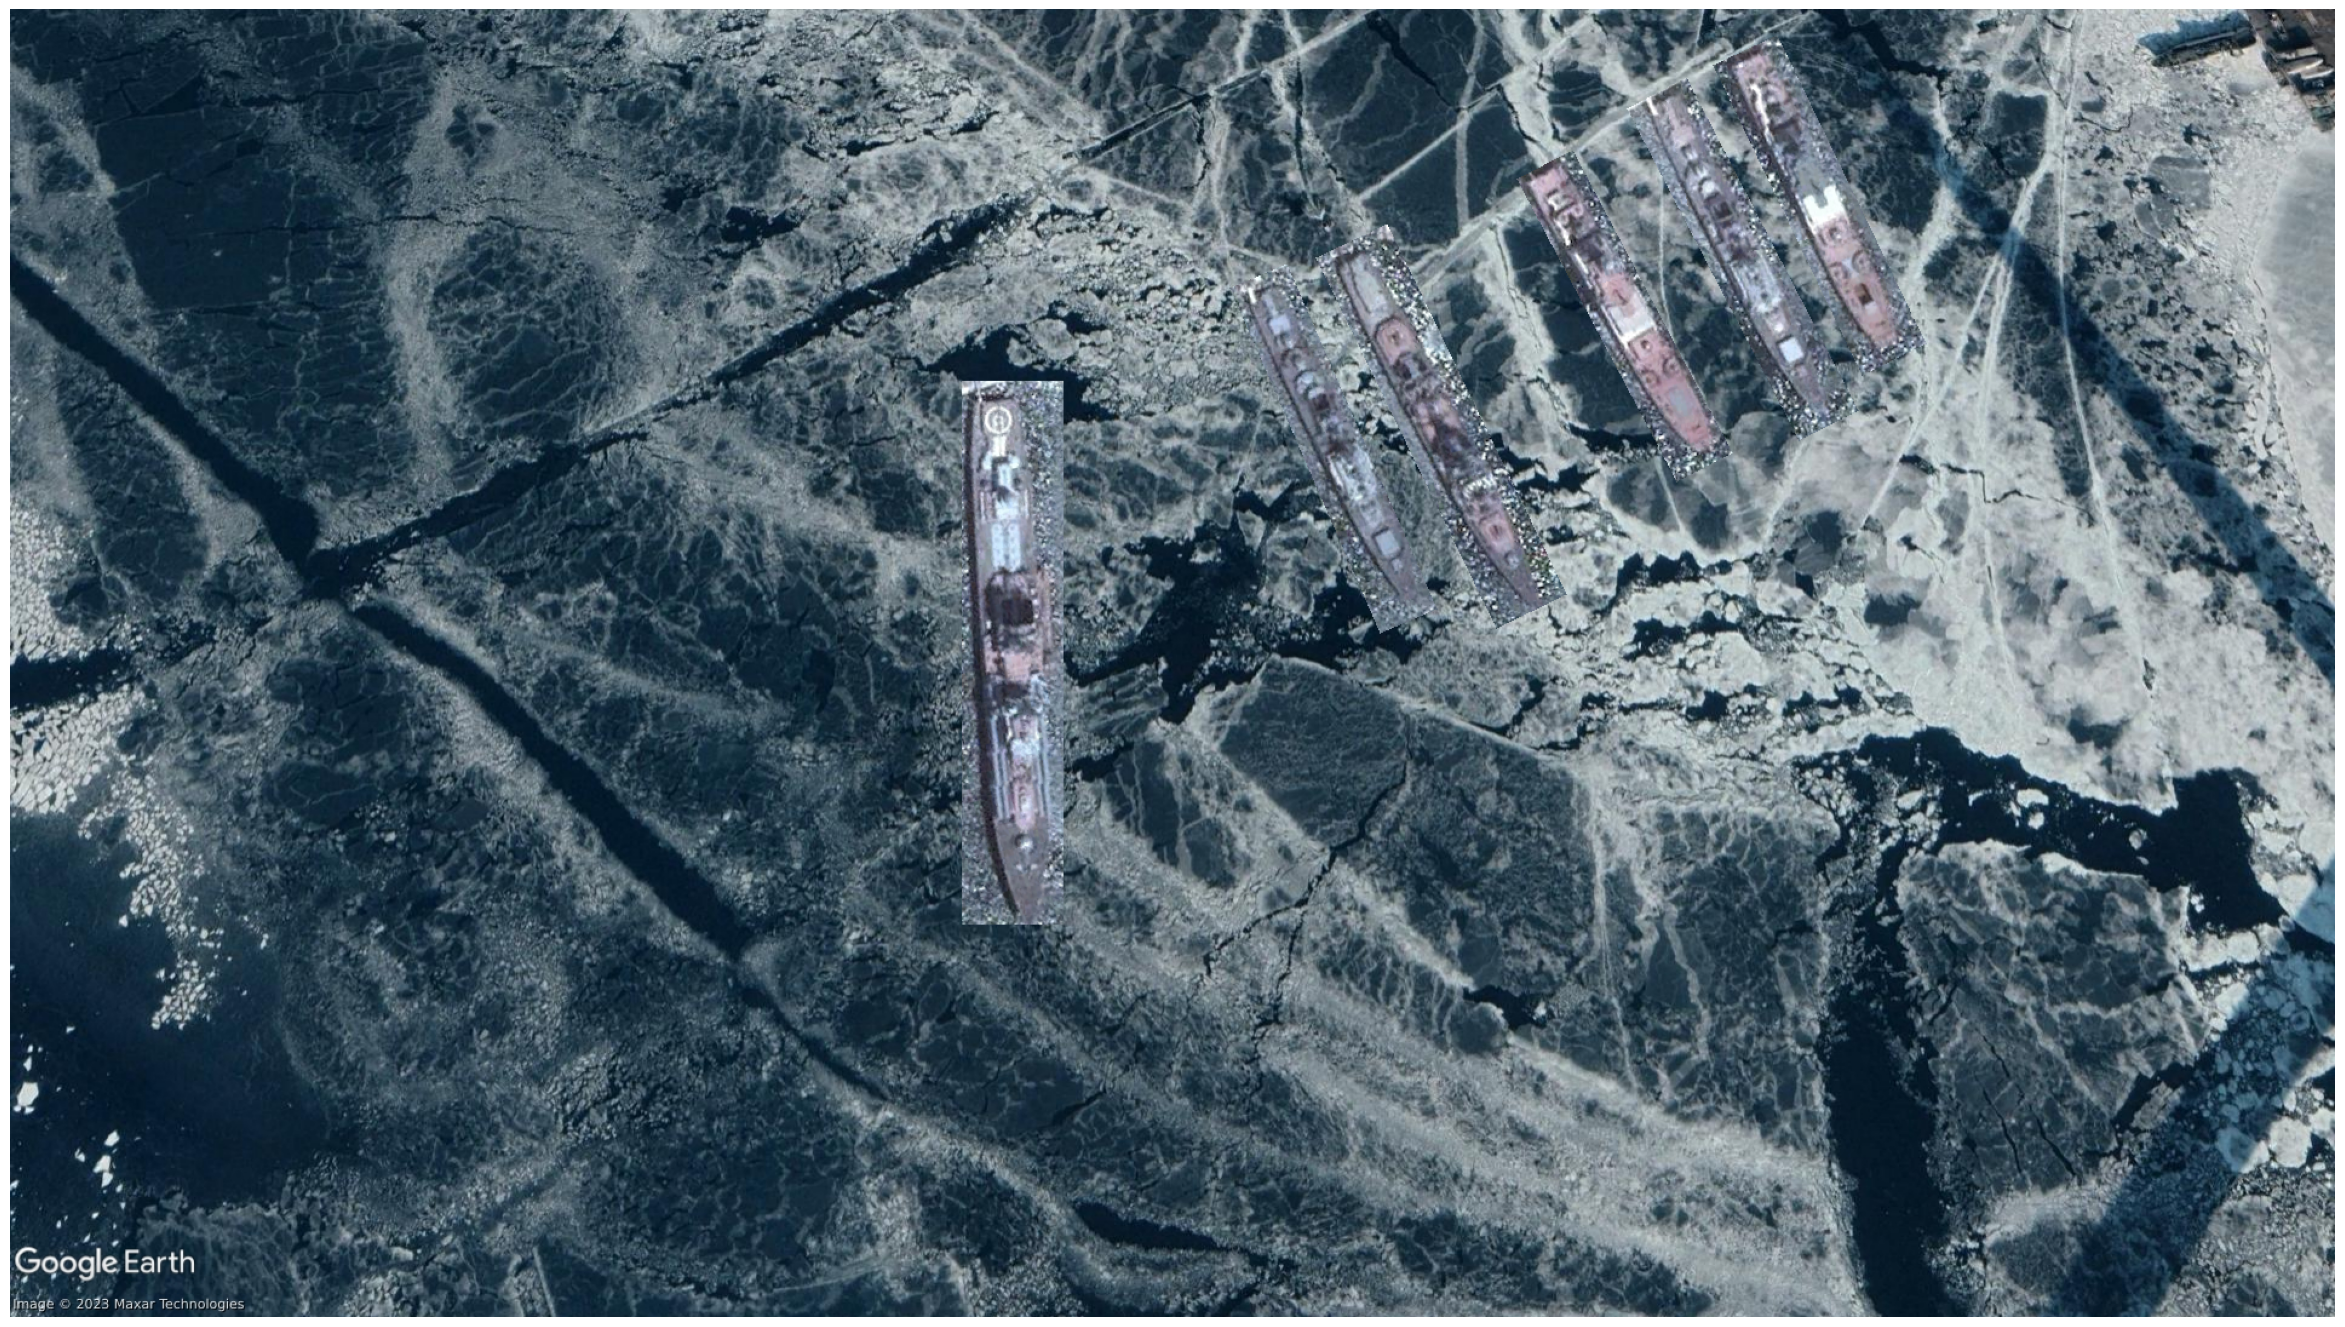

In [112]:
change_bg("000117ID_Sebastopol_1080HD_Maxar_715m_2005Y06M.png", df)

In [ ]:
# Generación de las particiones train, val, test

In [108]:
df["filename"] = df["filename"].str.rsplit("/",1).str[-1].str.split(".").str[0]

In [109]:
unique_files = df["filename"].unique()

In [143]:
index = 0
list_index = []
for unique_file in unique_files:
    if os.path.exists(os.path.join('/var/seda-datasets-ice/Annotations', unique_file+'.xml')) == False:
        print(unique_file)
        list_index.append(index)
    index +=1

000254ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000252ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000251ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000249ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000247ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000245ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000244ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000242ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000240ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000238ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000236ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000266ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000263ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000261ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000259ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000258ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000257ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000255ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000334ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000335ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000336ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
000368ID_Murmansk_1080HD_Maxar_162

In [144]:
modifiedArray = np.delete(unique_files, list_index)

In [145]:
dictionary = {"ids": modifiedArray}
ids_df = pd.DataFrame(dictionary)

In [146]:
ids_df

ids
0     000038ID_Kronstadt_1080HD_Maxar_1420m_2020Y08M
1     000037ID_Kronstadt_1080HD_Maxar_1420m_2020Y08M
2     000036ID_Kronstadt_1080HD_Maxar_1420m_2020Y08M
3     000035ID_Kronstadt_1080HD_Maxar_1420m_2020Y08M
4     000034ID_Kronstadt_1080HD_Maxar_1420m_2020Y08M
...                                              ...
1576  000031ID_Sebastopol_1080HD_Maxar_715m_2019Y12M
1577  000030ID_Sebastopol_1080HD_Maxar_715m_2019Y12M
1578  000029ID_Sebastopol_1080HD_Maxar_715m_2019Y12M
1579  000028ID_Sebastopol_1080HD_Maxar_715m_2019Y12M
1580  000027ID_Sebastopol_1080HD_Maxar_715m_2019Y12M

[1581 rows x 1 columns]

In [147]:
train, validate, test = train_validate_test_split(ids_df, seed=42)

In [148]:
display(train)
train.to_csv('/var/seda-datasets-ice/train.txt', header=None, index=None, sep=' ', mode='w')

ids
1124      000291ID_Murmansk_1080HD_Maxar_1620m_2020Y09M
813    000210ID_Vladivostok_1080HD_Maxar_1440m_2010Y06M
1175      000174ID_Murmansk_1080HD_Maxar_1620m_2020Y09M
534   000144ID_Petropaulousk-Kanchatskiy_1080HD_Maxa...
514      000112ID_Baltisysk_1080HD_Maxar_1060m_2020Y09M
...                                                 ...
1468   000044ID_Severomorsk_1080HD_Maxar_1620m_2019Y12M
1201      000126ID_Murmansk_1080HD_Maxar_1620m_2020Y09M
976    000057ID_Vladivostok_1080HD_Maxar_1440m_2020Y10M
1193      000155ID_Murmansk_1080HD_Maxar_1620m_2020Y09M
1573     000034ID_Sebastopol_1080HD_Maxar_715m_2019Y12M

[948 rows x 1 columns]

In [149]:
display(validate)
validate.to_csv('/var/seda-datasets-ice/val.txt', header=None, index=None, sep=' ', mode='w')

ids
7        000031ID_Kronstadt_1080HD_Maxar_1420m_2020Y08M
963    000120ID_Vladivostok_1080HD_Maxar_1440m_2020Y10M
667   000129ID_Petropaulousk-Kanchatskiy_1080HD_Maxa...
1221      000096ID_Murmansk_1080HD_Maxar_1620m_2020Y09M
357    000024ID_Karantinnaya_1080HD_Maxar_911m_2019Y12M
...                                                 ...
157    000209ID_Vladivostok_1080HD_Maxar_1440m_2020Y10M
1243      000060ID_Murmansk_1080HD_Maxar_1620m_2020Y09M
1195      000132ID_Murmansk_1080HD_Maxar_1620m_2020Y09M
16       000024ID_Kronstadt_1080HD_Maxar_1420m_2020Y08M
1072      000061ID_Murmansk_1080HD_Maxar_1620m_2005Y07M

[316 rows x 1 columns]

In [150]:
display(test)
test.to_csv('/var/seda-datasets-ice/test.txt', header=None, index=None, sep=' ', mode='w')

ids
1556     000127ID_Sebastopol_1080HD_Maxar_715m_2019Y12M
546   000127ID_Petropaulousk-Kanchatskiy_1080HD_Maxa...
658   000138ID_Petropaulousk-Kanchatskiy_1080HD_Maxa...
1383   000162ID_Severomorsk_1080HD_Maxar_1620m_2019Y12M
1019      000147ID_Murmansk_1080HD_Maxar_1620m_2005Y07M
...                                                 ...
1130      000266ID_Murmansk_1080HD_Maxar_1620m_2020Y09M
1294   000147ID_Severomorsk_1080HD_Maxar_1620m_2009Y10M
860    000112ID_Vladivostok_1080HD_Maxar_1440m_2010Y06M
1459   000056ID_Severomorsk_1080HD_Maxar_1620m_2019Y12M
1126      000289ID_Murmansk_1080HD_Maxar_1620m_2020Y09M

[317 rows x 1 columns]